## import

In [1]:
import tensorflow as tf

In [2]:
tf.enable_eager_execution()

In [3]:
import pandas as pd

In [26]:
import numpy as np

## 데이터 불러오기

In [4]:
df = pd.read_csv('000270.csv')

In [5]:
df.head()

,date,close,diff,open,high,low,volume
0,1996.06.25,14300.0,0.0,14500.0,14500.0,14300.0,63430.0
1,1996.06.26,14100.0,200.0,14300.0,14300.0,14000.0,57270.0
2,1996.06.27,14400.0,300.0,14100.0,14600.0,14000.0,35870.0
3,1996.06.28,14500.0,100.0,14400.0,14700.0,14300.0,60850.0
4,1996.06.29,14400.0,100.0,14400.0,14600.0,14300.0,32310.0


## 가격 추이

In [8]:
%matplotlib inline

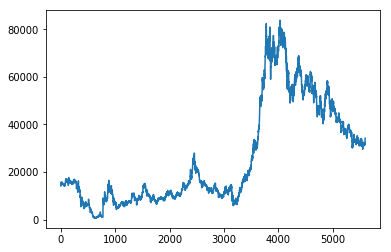

In [10]:
df['close'].plot()

## 차분

In [12]:
diff = df['close'] - df['open']

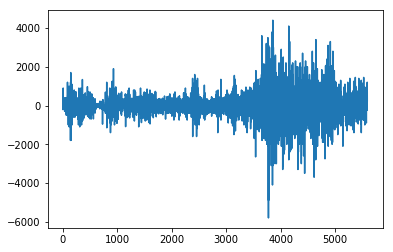

In [13]:
diff.plot()

In [16]:
diff.mean()

-12.58044333214158

In [17]:
diff.std()

628.8719756767784

In [18]:
Z_diff = (diff - diff.mean()) / diff.std()

## 입력 데이터 형식 변환

In [240]:
input_data = np.reshape(Z_diff.values, (1, len(Z_diff), 1))

In [241]:
input_data.shape

(1, 5594, 1)

## 모형

In [199]:
class StockTrader(tf.keras.models.Model):
    def __init__(self):
        super().__init__()
        self.lstm = tf.contrib.rnn.BasicLSTMCell(16, dtype=tf.float32)
        self.initial_state = lstm.zero_state(1, dtype=tf.float32)
        self.action_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(3))
        
    def __call__(self, input_data):
        outputs, state = tf.nn.dynamic_rnn(
            cell=self.lstm, 
            inputs=input_data.astype(np.float32),
            initial_state=self.initial_state,
            dtype=tf.float32)
        return self.action_layer(outputs)[0]

In [200]:
trader = StockTrader()

In [201]:
logits = trader(input_data)

## action

In [152]:
action = tf.multinomial(logits, 1)[:, 0]

In [153]:
action

<tf.Tensor: id=858377, shape=(5594,), dtype=int64, numpy=array([0, 1, 2, ..., 0, 0, 1], dtype=int64)>

- 0: 산다
- 1: 보유
- 2: 판다

## reward

In [223]:
def calc_reward(action, prices):
    stock = 0
    money = 1000000
    reward = []
    units = 10
    for a, price in zip(action, df['close']):
        if a.numpy() == 0:  # 산다
            if money > price * units: # 살 돈이 있으면
                stock += units  # 주식은 늘고
                money -= price * units  # 돈은 줄어듦
                reward.append(-price * units)
            else:  # 살 돈이 없으면
                reward.append(0)
        elif a.numpy() == 1:  # 보유
            reward.append(0)
        else:  # 판다
            if stock > 0:  # 주식이 있으면
                stock -= units  # 주식은 줄고
                money += price * units  # 돈은 늘어남
                reward.append(price * units)
            else:
                reward.append(0)

    reward[-1] += stock * price  # 기간 종료 후에는 청산
    return reward

In [225]:
reward = calc_reward(action, df['close'])

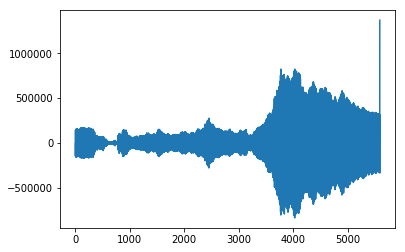

In [226]:
pyplot.plot(reward)

## return

In [227]:
def calc_returns(reward, discount=0.99):
    returns = []

    next_return = 0

    for r in reversed(reward):
        next_return = r + discount * next_return
        returns.append(next_return)
    
    return np.array(returns[::-1])

In [228]:
returns = calc_returns(reward)

In [233]:
norm_ret = returns / np.max(np.abs(returns))

In [160]:
from matplotlib import pyplot

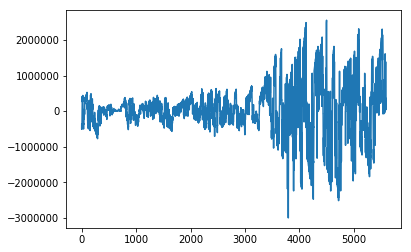

In [229]:
pyplot.plot(returns)

## 경사하강법

In [217]:
with tf.contrib.eager.GradientTape() as tape:
    logits = trader(input_data)
    log_p = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=action, logits=logits)
    target = tf.reduce_sum(norm_ret * log_p)

In [218]:
grad = tape.gradient(target, trader.trainable_variables)

In [220]:
adam =  tf.train.AdamOptimizer()

In [222]:
adam.apply_gradients(zip(grad, trader.trainable_variables))

## 종합

In [234]:
for _ in range(30):
    logits = trader(input_data)
    action = tf.multinomial(logits, 1)[:, 0]

    reward = calc_reward(action, df['close'])
    returns = calc_returns(reward)
    print(returns[0])

    norm_ret = norm_ret = returns / np.max(np.abs(returns))

    with tf.contrib.eager.GradientTape() as tape:
        logits = trader(input_data)
        log_p = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=action, logits=logits)
        target = tf.reduce_sum(norm_ret * log_p)

    grad = tape.gradient(target, trader.trainable_variables)

    adam.apply_gradients(zip(grad, trader.trainable_variables))

-412514.5067844568
-442839.2292264557
-368545.10167523357
-332874.1628170989
-284393.73427200445
-346377.2302135664
-348431.4966338613
-355848.80621549475
-335405.574498042
-454014.25379990827
-180280.26111696698
-340627.6592789969
-297359.8737535939
-277672.2249573391
-231237.97525860253
-210413.04301193432
-377754.1999103571
-396048.2083596708
-402049.60935928667
-223747.82219316068
-344550.6071848131
-337124.7932524029
-174170.36560506572
-175724.3279492116
-522001.0106259631
-126815.90936506024
-254718.86612772074
-232265.1054508829
-145284.58018309783
-165838.422733631
